In [1]:
import pyspark
from pyspark.sql import SparkSession
from graphframes import GraphFrame

import json
import networkx as nx
import re
from matplotlib import pyplot as plt
from igraph import Graph, plot
import pandas as pd
from pandas.core.common import flatten

In [2]:
LENGTHS_OF_K_MERS = [4]
LENGTH_OF_Q_MERS = 30   # q (short: 20, long: 30, 3species: 10)
NUM_SHARED_READS = 45   # m (short: 5, long: 45, 3species: 2)
N_WORKERS = 30
DATA_PATH = "../data/R4_medium/"
FILENAME_VERTICES = DATA_PATH + 'output_1_1_2.txt'
FILENAME_EDGES = DATA_PATH + 'output_2_1_2.txt'
IS_TFIDF = False
SMARTIRS = None
MAXIMUM_COMPONENT_SIZE = 400 # R*: 400, S*: 200, 3species_S: 50

# BiMeta

Example of how to use `pyspark` and `graphframe` is in `test/spark/hello_graph.ipynb` 

## Read input file

### Read vertices

In [3]:
# Test clean line method
with open(FILENAME_VERTICES) as f:
    content = f.readlines()
    
a = content[0]

# Notice: There are differences between raw input and print()

# Long method
# a.replace('null\t', '').replace('\n', '').replace('[', '').replace(']', '').replace(' "','').replace('"','').split(',')

# Better method with regex
re.sub('[null\t\n\[\]\""]', '', a).replace(' ', '').split(',')

['0',
 'AAACCCTCTTCCACGAACCCTCTTGAAAATCCCCCACATCCACAAAATAAATCAAATAAATTTCAACATTATCACCAAAAGGGTAAAAGGTTATTTAAAAAATAAAATAAATTTAAAAATTTAAATTAAATACCAAAAAAGCCAAATAACTTATTGTGATTCTTGAGCTTTCTTTAACTCTGCCTTCATATCTTGATAGACTTTAGTCCATTTTAATTTTCTTGGATTTCTTCCCATTCTGTAGCTTTTCTCACATTTGGATGAGCAGAAATATAATACAGTCCCATCTTTTTCTACGACCATTTTTCCTTTTCCTGGCTCAATTTCATAACCACAAAAGCTGCATGTTCTCCATTCTGGCATAGCTATCCCCCTTTAATAGTGTTTCAGTGATTTTAAAATAATTTAAGATTAAATTATTTATCTTCTTCTGTCTAATGGTCTTGCTTCTCTCTCTGTTTCTCTTAACATAATAATGTCTCCAACTTTAACTGGACCTTTAACGTTTCTAACTAAAACTCTTCCAGTATCTTTTCCACCTAAGATTTTACATCTAACTTGTATAATTCCTCCAGTAACCCCTGTTCTACCAATGACTTCAATAACTTCAGCAGCTACTGCTTCCTTATAAACAAATTCATCTTCCGATCCTCATCACCTAATATTAATGAAGGTTTAAAATTTATAAAAAAGTTAGTAGTAGTGTTTCATAATTTATATAATAATAACTATATACTATTGATTGATGGTTAAATAGCGTTCTAATAATTTACTGCTTCAAAACATTTACCTTTTCAATTAATACCTTTAACTCTTCAGCATCTCCTTCGTTG',
 '0']

In [4]:
V = []

with open(FILENAME_VERTICES) as f:
    content_vertices = f.readlines()

for line in content_vertices:
    clean_line = re.sub('[null\t\n\[\]\""]', '', line).replace(' ', '').split(',')
    V.append(clean_line)
    
print(V[:2])

[['0', 'AAACCCTCTTCCACGAACCCTCTTGAAAATCCCCCACATCCACAAAATAAATCAAATAAATTTCAACATTATCACCAAAAGGGTAAAAGGTTATTTAAAAAATAAAATAAATTTAAAAATTTAAATTAAATACCAAAAAAGCCAAATAACTTATTGTGATTCTTGAGCTTTCTTTAACTCTGCCTTCATATCTTGATAGACTTTAGTCCATTTTAATTTTCTTGGATTTCTTCCCATTCTGTAGCTTTTCTCACATTTGGATGAGCAGAAATATAATACAGTCCCATCTTTTTCTACGACCATTTTTCCTTTTCCTGGCTCAATTTCATAACCACAAAAGCTGCATGTTCTCCATTCTGGCATAGCTATCCCCCTTTAATAGTGTTTCAGTGATTTTAAAATAATTTAAGATTAAATTATTTATCTTCTTCTGTCTAATGGTCTTGCTTCTCTCTCTGTTTCTCTTAACATAATAATGTCTCCAACTTTAACTGGACCTTTAACGTTTCTAACTAAAACTCTTCCAGTATCTTTTCCACCTAAGATTTTACATCTAACTTGTATAATTCCTCCAGTAACCCCTGTTCTACCAATGACTTCAATAACTTCAGCAGCTACTGCTTCCTTATAAACAAATTCATCTTCCGATCCTCATCACCTAATATTAATGAAGGTTTAAAATTTATAAAAAAGTTAGTAGTAGTGTTTCATAATTTATATAATAATAACTATATACTATTGATTGATGGTTAAATAGCGTTCTAATAATTTACTGCTTCAAAACATTTACCTTTTCAATTAATACCTTTAACTCTTCAGCATCTCCTTCGTTG', '0'], ['1', 'TAGCATGTAAATCCCTTATTTCTTAATTTCTCCCAGAATTATTTCTATTGCTTTATCAACTGCCTTGGCAACCTCTTCAGACAACCCTGGTTTTATGTCTGGCATTGTAAATTTTTACCTTGACAACCAATAACCACGACTTC

In [5]:
df_vertices = pd.DataFrame(V, columns=["id", "read", "label"])
df_vertices.head()

,id,read,label
0,0,AAACCCTCTTCCACGAACCCTCTTGAAAATCCCCCACATCCACAAA...,0
1,1,TAGCATGTAAATCCCTTATTTCTTAATTTCTCCCAGAATTATTTCT...,0
2,2,CTCCACTTGTTAGAAAAAGATTTATACTAAACTAAGATATTAGGTT...,0
3,3,TGGACTTAACTTAGTCCCAAGAACAACAGTAACTGGTTCAGTAATT...,0
4,4,AACCTTGCGGGAAGAGAACGTTAAAGCCCTTCATCCTCTTGTATCT...,0


In [6]:
df_vertices.size

3843

### Read edges

In [7]:
# Method 1: Format input file as dictionary format like original notebook code

E = {}

with open(FILENAME_EDGES) as f:
    content_edges = f.readlines()

for line in content_edges:
    # Get number character only -> remove leading and trailing whitespaces -> splits a string into a list (separator: whitespace)
    clean_line = re.sub("[^0-9]", " ", line).strip().split()
    e_curr = (clean_line[0],  clean_line[1])
    E[e_curr] = clean_line[2]
    
# print(E)
# Print the first 5 pairs
print({k: E[k] for k in sorted(E.keys())[:5]})

{('0', '362'): '394', ('0', '407'): '531', ('1', '299'): '439', ('1001', '1191'): '265', ('1009', '1241'): '411'}


In [8]:
# Contain pairs of reads that is connected (edge weight >= NUM_SHARED_READS is connected)
E_Filtered = {kv[0]: kv[1] for kv in E.items() if int(kv[1]) >= NUM_SHARED_READS}
E_Filtered

{('735', '1183'): '159',
 ('736', '880'): '547',
 ('741', '938'): '205',
 ('744', '837'): '202',
 ('756', '977'): '277',
 ('772', '1188'): '604',
 ('772', '903'): '446',
 ('783', '1099'): '244',
 ('787', '1267'): '236',
 ('788', '870'): '48',
 ('804', '912'): '377',
 ('807', '1182'): '272',
 ('81', '410'): '538',
 ('810', '1112'): '410',
 ('810', '828'): '322',
 ('813', '932'): '170',
 ('818', '1210'): '63',
 ('823', '914'): '100',
 ('825', '1045'): '337',
 ('828', '1055'): '279',
 ('83', '395'): '110',
 ('830', '929'): '411',
 ('835', '1064'): '240',
 ('846', '976'): '408',
 ('847', '1278'): '500',
 ('854', '1166'): '494',
 ('859', '953'): '236',
 ('863', '873'): '467',
 ('871', '1087'): '293',
 ('875', '1247'): '46',
 ('884', '891'): '121',
 ('893', '1069'): '89',
 ('898', '1269'): '422',
 ('899', '1061'): '66',
 ('903', '1188'): '426',
 ('907', '1060'): '145',
 ('91', '105'): '125',
 ('926', '1242'): '397',
 ('94', '103'): '431',
 ('94', '146'): '573',
 ('940', '1068'): '413',
 ('94

In [9]:
print("E:", len(E))
print("E_Filtered:", len(E_Filtered))

E: 215
E_Filtered: 192


In [10]:
# Method 2: Format input file as list format for easier to create dataframe - Use this method

E = []

with open(FILENAME_EDGES) as f:
    content_edges = f.readlines()

for line in content_edges:
    # Get number character only -> remove leading and trailing whitespaces -> splits a string into a list (separator: whitespace)
    clean_line = re.sub("[^0-9]", " ", line).strip().split()
    E.append([clean_line[0],  clean_line[1], clean_line[2]])
    
# print(E)
print(E[:5])

[['735', '1183', '159'], ['736', '880', '547'], ['741', '938', '205'], ['744', '837', '202'], ['756', '977', '277']]


In [11]:
E_Filtered = [kv for kv in E if int(kv[2]) >= NUM_SHARED_READS]
E_Filtered

[['735', '1183', '159'],
 ['736', '880', '547'],
 ['741', '938', '205'],
 ['744', '837', '202'],
 ['756', '977', '277'],
 ['772', '1188', '604'],
 ['772', '903', '446'],
 ['783', '1099', '244'],
 ['787', '1267', '236'],
 ['788', '870', '48'],
 ['804', '912', '377'],
 ['807', '1182', '272'],
 ['81', '410', '538'],
 ['810', '1112', '410'],
 ['810', '828', '322'],
 ['813', '932', '170'],
 ['818', '1210', '63'],
 ['823', '914', '100'],
 ['825', '1045', '337'],
 ['828', '1055', '279'],
 ['83', '395', '110'],
 ['830', '929', '411'],
 ['835', '1064', '240'],
 ['846', '976', '408'],
 ['847', '1278', '500'],
 ['854', '1166', '494'],
 ['859', '953', '236'],
 ['863', '873', '467'],
 ['871', '1087', '293'],
 ['875', '1247', '46'],
 ['884', '891', '121'],
 ['893', '1069', '89'],
 ['898', '1269', '422'],
 ['899', '1061', '66'],
 ['903', '1188', '426'],
 ['907', '1060', '145'],
 ['91', '105', '125'],
 ['926', '1242', '397'],
 ['94', '103', '431'],
 ['94', '146', '573'],
 ['940', '1068', '413'],
 ['94

In [12]:
df_edges = pd.DataFrame(E_Filtered, columns=['src', 'dst', 'weight'])
df_edges.head()

,src,dst,weight
0,735,1183,159
1,736,880,547
2,741,938,205
3,744,837,202
4,756,977,277


In [13]:
# Original notebook code using networkx

def build_graph(E_Filtered, labels):
    # Building graph
    G = nx.Graph()
    # Adding nodes
    color_map = {
        0: "red",
        1: "green",
        2: "blue",
        3: "yellow",
        4: "darkcyan",
        5: "violet",
        6: "black",
        7: "grey",
        8: "sienna",
        9: "wheat",
        10: "olive",
        11: "lightgreen",
        12: "cyan",
        13: "slategray",
        14: "navy",
        15: "hotpink",
    }
    for i in range(0, len(labels)):
        G.add_node(i, label=labels[i], color=color_map[labels[i]])

    # Adding edges
    for kv in E_Filtered.items():
        G.add_edge(kv[0][0], kv[0][1], weight=kv[1])

    return G

## Create graph

In [14]:
spark = SparkSession.builder.appName("build_graph").getOrCreate()

In [15]:
vertices = spark.createDataFrame(df_vertices)

In [16]:
edges = spark.createDataFrame(df_edges)

In [17]:
g = GraphFrame(vertices, edges)

In [18]:
g.vertices.show()

+---+--------------------+-----+
| id|                read|label|
+---+--------------------+-----+
|  0|AAACCCTCTTCCACGAA...|    0|
|  1|TAGCATGTAAATCCCTT...|    0|
|  2|CTCCACTTGTTAGAAAA...|    0|
|  3|TGGACTTAACTTAGTCC...|    0|
|  4|AACCTTGCGGGAAGAGA...|    0|
|  5|AAGATTTCTCTTTCTTC...|    0|
|  6|TATCTTCATCAGCAGTA...|    0|
|  7|TCCATAATTAATCACCT...|    0|
|  8|GTTTTCTTTAACATACA...|    0|
|  9|ATGGTTTTATTGCAGTC...|    0|
| 10|TGATTTTTATGGAGATT...|    0|
| 11|TTTTTATTTAATACTTT...|    0|
| 12|CCAATCTTTTAATTTCC...|    0|
| 13|AAGAGGAGCTACTGTAA...|    0|
| 14|AACTCCCAGTGGAACAT...|    0|
| 15|GGATAATGACAAATATG...|    0|
| 16|TGACTTTGTATTTGTTG...|    0|
| 17|GGTGGAGATGCTGTTTT...|    0|
| 18|CAATGATTGGTTTAGTA...|    0|
| 19|TAATCGGTAACCCAAAC...|    0|
+---+--------------------+-----+
only showing top 20 rows



In [19]:
g.edges.show()

+---+----+------+
|src| dst|weight|
+---+----+------+
|735|1183|   159|
|736| 880|   547|
|741| 938|   205|
|744| 837|   202|
|756| 977|   277|
|772|1188|   604|
|772| 903|   446|
|783|1099|   244|
|787|1267|   236|
|788| 870|    48|
|804| 912|   377|
|807|1182|   272|
| 81| 410|   538|
|810|1112|   410|
|810| 828|   322|
|813| 932|   170|
|818|1210|    63|
|823| 914|   100|
|825|1045|   337|
|828|1055|   279|
+---+----+------+
only showing top 20 rows



## Visualize graph

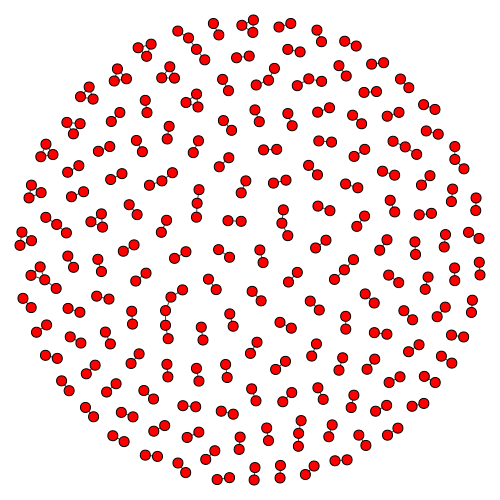

In [20]:
ig = Graph.TupleList(g.edges.collect(), directed=False)
plot(ig, vertex_size=10, bbox=(0, 0, 500, 500))

## Subgraph

In [21]:
# Statement inside filter() have to be str
paths = g.find("(a)-[e]->(b)").filter("e.weight >" + str(MAXIMUM_COMPONENT_SIZE))

# e.*: get all attributes of edges ("e.src", "e.dst", "e.weight")
e2 = paths.select("e.*")

# Construct the subgraph
g2 = GraphFrame(g.vertices, e2)

In [22]:
g2.edges.show()

+----+----+------+
| src| dst|weight|
+----+----+------+
|1009|1241|   411|
| 732| 926|   594|
| 367| 448|   404|
|1085|1236|   454|
| 108| 200|   525|
| 810|1112|   410|
| 134| 279|   527|
| 297| 478|   571|
| 736| 880|   547|
| 772| 903|   446|
|  94| 146|   573|
|  81| 410|   538|
| 898|1269|   422|
| 259| 390|   584|
|1173|1228|   501|
| 721|1278|   487|
| 847|1278|   500|
| 352| 440|   490|
| 723| 804|   581|
| 121| 300|   655|
+----+----+------+
only showing top 20 rows



In [23]:
g2.vertices.show()

+---+--------------------+-----+
| id|                read|label|
+---+--------------------+-----+
|  0|AAACCCTCTTCCACGAA...|    0|
|  1|TAGCATGTAAATCCCTT...|    0|
|  2|CTCCACTTGTTAGAAAA...|    0|
|  3|TGGACTTAACTTAGTCC...|    0|
|  4|AACCTTGCGGGAAGAGA...|    0|
|  5|AAGATTTCTCTTTCTTC...|    0|
|  6|TATCTTCATCAGCAGTA...|    0|
|  7|TCCATAATTAATCACCT...|    0|
|  8|GTTTTCTTTAACATACA...|    0|
|  9|ATGGTTTTATTGCAGTC...|    0|
| 10|TGATTTTTATGGAGATT...|    0|
| 11|TTTTTATTTAATACTTT...|    0|
| 12|CCAATCTTTTAATTTCC...|    0|
| 13|AAGAGGAGCTACTGTAA...|    0|
| 14|AACTCCCAGTGGAACAT...|    0|
| 15|GGATAATGACAAATATG...|    0|
| 16|TGACTTTGTATTTGTTG...|    0|
| 17|GGTGGAGATGCTGTTTT...|    0|
| 18|CAATGATTGGTTTAGTA...|    0|
| 19|TAATCGGTAACCCAAAC...|    0|
+---+--------------------+-----+
only showing top 20 rows



## Connected Components

In [24]:
sc.setCheckpointDir(dirName="/home/dhuy237/graphframes_cps")

result = g.connectedComponents()
result.select("id", "component").orderBy("component").show()

+----+-----------+
|  id|  component|
+----+-----------+
|1090|          0|
|1159|          1|
| 303|          2|
| 296|          2|
| 467|          3|
| 675|          4|
| 691|          5|
| 829|          6|
| 125| 8589934592|
| 451| 8589934593|
| 800| 8589934594|
| 561| 8589934595|
| 853| 8589934595|
| 944| 8589934596|
|1009|17179869184|
|1241|17179869184|
|1268|17179869185|
|1265|17179869185|
|1280|17179869186|
| 761|17179869187|
+----+-----------+
only showing top 20 rows



In [25]:
# Unique component
len(result.select('component').distinct().collect())

1101

In [26]:
# Number of rows
result.count()

1281

In [27]:
mvv = result.select("component").rdd.flatMap(lambda x: x).collect()
len(mvv)

1281

In [28]:
result.select("id", "component").show()

+---+-------------+
| id|    component|
+---+-------------+
|  0| 300647710720|
|  1|1219770712066|
|  2|1623497637892|
|  3| 154618822658|
|  4|1425929142275|
|  5| 420906795012|
|  6| 644245094403|
|  7|  25769803780|
|  8| 223338299395|
|  9|1194000908297|
| 10|1331439861760|
| 11|  94489280515|
| 12|1460288880641|
| 13|1503238553605|
| 14|1520418422784|
| 15|  60129542145|
| 16| 283467841538|
| 17| 532575944707|
| 18| 455266533376|
| 19| 730144440322|
+---+-------------+
only showing top 20 rows



In [29]:
a = result.select("id", "component").orderBy('component', ascending=False)
a.show()

+----+-------------+
|  id|    component|
+----+-------------+
| 438|1709396983810|
|1251|1709396983809|
| 119|1700807049217|
| 937|1692217114630|
| 881|1692217114628|
| 820|1692217114627|
| 572|1692217114626|
| 522|1692217114625|
| 216|1692217114624|
| 861|1683627180037|
|  57|1683627180036|
| 553|1683627180035|
| 542|1683627180034|
| 332|1683627180032|
| 946|1675037245446|
| 920|1675037245445|
|  50|1675037245444|
| 330|1675037245443|
| 145|1675037245442|
|1222|1675037245441|
+----+-------------+
only showing top 20 rows



In [30]:
a.count()

1281

In [31]:
dictionary = {}

for row in a.collect():
    if row[1] in dictionary:
        dictionary[row[1]].append(row[0])
    else:
        dictionary[row[1]] = [row[0]]

dictionary

{1709396983810: ['438'],
 1709396983809: ['1251'],
 1700807049217: ['119'],
 1692217114630: ['937'],
 1692217114628: ['881'],
 1692217114627: ['820'],
 1692217114626: ['572'],
 1692217114625: ['522'],
 1692217114624: ['216'],
 1683627180037: ['861'],
 1683627180036: ['57'],
 1683627180035: ['553'],
 1683627180034: ['542'],
 1683627180032: ['332'],
 1675037245446: ['946'],
 1675037245445: ['920'],
 1675037245444: ['50'],
 1675037245443: ['330'],
 1675037245442: ['145'],
 1675037245441: ['1222'],
 1666447310851: ['872'],
 1666447310850: ['532'],
 1666447310849: ['1224'],
 1657857376257: ['611'],
 1649267441671: ['814'],
 1649267441670: ['80'],
 1649267441668: ['569'],
 1649267441667: ['504'],
 1649267441666: ['340'],
 1649267441664: ['226'],
 1640677507083: ['972'],
 1640677507082: ['956'],
 1640677507081: ['848'],
 1640677507080: ['664'],
 1640677507079: ['655'],
 1640677507078: ['590'],
 1640677507077: ['435'],
 1640677507076: ['311'],
 1640677507074: ['1223'],
 1640677507072: ['1091']

In [32]:
GL = []

for key, value in dictionary.items():
    GL.append(value)
    
GL

[['438'],
 ['1251'],
 ['119'],
 ['937'],
 ['881'],
 ['820'],
 ['572'],
 ['522'],
 ['216'],
 ['861'],
 ['57'],
 ['553'],
 ['542'],
 ['332'],
 ['946'],
 ['920'],
 ['50'],
 ['330'],
 ['145'],
 ['1222'],
 ['872'],
 ['532'],
 ['1224'],
 ['611'],
 ['814'],
 ['80'],
 ['569'],
 ['504'],
 ['340'],
 ['226'],
 ['972'],
 ['956'],
 ['848'],
 ['664'],
 ['655'],
 ['590'],
 ['435'],
 ['311'],
 ['1223'],
 ['1091'],
 ['765'],
 ['370'],
 ['254'],
 ['460'],
 ['278'],
 ['2'],
 ['1154'],
 ['1125'],
 ['1002'],
 ['942'],
 ['76'],
 ['674'],
 ['608'],
 ['529'],
 ['378'],
 ['579'],
 ['368'],
 ['1153'],
 ['984'],
 ['499'],
 ['262'],
 ['1047'],
 ['809'],
 ['791'],
 ['925'],
 ['487'],
 ['321'],
 ['1178'],
 ['1102'],
 ['661'],
 ['355'],
 ['151'],
 ['923'],
 ['758'],
 ['677'],
 ['392'],
 ['1219'],
 ['1073'],
 ['161'],
 ['767'],
 ['74'],
 ['72'],
 ['469'],
 ['137'],
 ['1279'],
 ['771'],
 ['760'],
 ['175', '196'],
 ['1164'],
 ['1101'],
 ['66'],
 ['651'],
 ['508'],
 ['264'],
 ['1121'],
 ['1098'],
 ['939'],
 ['831'],
 ['

In [34]:
# Save output as (key, value) format
# key: null
# value: each item in the GL list

# Note: Remember to export in json format for MapReduce job be able to read the file

with open(DATA_PATH+'output_2_2.txt', 'w+') as f:
    for item in GL:
        f.write("null\t%s\n" % json.dumps(item))